In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
#This time, we import a useful library for uncertainties called "uncertainties"
from uncertainties import ufloat

In [3]:
import astropy
from astropy.io import fits
from astropy import constants as ac
from astropy import units as u

In [4]:
import os

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [6]:
import corner

In [7]:
import radvel

In [8]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [9]:
#We add the parameters of our planet.
radius, upper_rad_err, lower_rad_err = 1.5353, 0.0333, 0.0324 #Earth Radius
mass, upper_mass_err, lower_mass_err = 6.2059, 1.1861, 1.1700  #Earth Mass
period, upper_per_err, lower_per_err = 0.2241957793, 0.0000000542, 0.0000000553  #Days

In [10]:
#We have to calculate the Insolation Flux of our planet in Earth Flux units.
#To do this we need:
    #Stellar Radius: R_star => In units of Solar Mass
    #Effective Temperature: T_eff => In units of Kelvin
    #Semi-Major Axis: a => In units of AU
#We obtain these values from both ariadne fit and the FCO RV-Transit Joint fit we have conducted.
R_star = 0.651
R_star_err = 0.012
T_eff = 4080
T_eff_err = 77
sma = 0.0063
sma_err = 0.0001

#Now that we have these values, we can obtain the Insolation Flux.
#But to also obtain the errors, we will sample from the posteriors of these parameters.
#For this case, we can sample 10000 samples from the posteriors
R_star_posterior = np.random.normal(0.651, 0.012, 10000)
T_eff_posterior = np.random.normal(4080, 77, 10000)
sma_posterior = np.random.normal(0.0063, 0.0001, 10000)

insolationfluxposterior = (R_star_posterior**2) * (T_eff_posterior/5778)**4 * (1/sma_posterior)**2

insolationfluxposterior

array([2589.41672622, 2652.71837355, 2737.73133189, ..., 2542.16389104,
       2504.32645563, 2920.61503263])

In [11]:
#We can use the function below to get the Insolation Flux median and errors.
def get_vals(vec, print_result = False, param_name = None):
    fvec   = np.sort(vec)

    fval  = np.median(fvec)
    nn = int(np.around(len(fvec)*0.15865))

    vali,valf = fval - fvec[nn],fvec[-nn] - fval
    
    if print_result == True:
        print(f"{param_name}: {fval:.6f} +{valf:.6f} -{vali:.6f}")
    
    return fval,vali,valf

In [12]:
insolationflux, insolationflux_lower, insolationflux_upper = get_vals(insolationfluxposterior)

print(f"Insolation Flux: {insolationflux:.3f} +{insolationflux_upper:.3f} -{insolationflux_lower:.3f} Earth Flux")

Insolation Flux: 2651.959 +248.630 -228.088 Earth Flux


In [13]:
#Now we import all the planets that have a confirmed mass and radius.
planet_file = '../../data/toi2431_extra/exoplanetdatawithinsolation.csv'
planet_df = pd.read_csv(planet_file, comment = "#")

#We call in the insolation fluxes. (In Earth Flux units)
insol_flux = planet_df["pl_insol"]
insol_flux_err1 = planet_df["pl_insolerr1"] #Upper Error
insol_flux_err2 = planet_df["pl_insolerr2"] #Lower Error

#We also filter out the masses that are not in %33 of the median value i.e. %33 of its own mass.
mass_threshold_pop = 0.33 * planet_df["pl_bmasse"].values

In [14]:
#Bring in two calculating functions from pyastrotools. (https://github.com/shbhuk/pyastrotools/)
def calculate_semi_major_axis(st_mass, pl_orbper, st_masserr1=0.0, pl_orbpererr1=0.0):
	"""
	Calculate the Semi Major Axis given the orbital period and the stellar mass.
	INPUTS:
		st_mass = Stellar Mass in Solar Masses
		st_masserr1 = Error
		pl_orbper = Orbital Period in years
		pl_orbpererr1 = Error
	OUTPUTS:
		pl_orbsmax = In AU

	from pyastrotools.astro_tools
	Shubham Kanodia 27th April 2021

	"""

	pl_orbper = (pl_orbper*u.yr).to(u.s).value
	pl_orbpererr1 = (pl_orbpererr1*u.yr).to(u.s).value
	pl_orbper = ufloat(pl_orbper, pl_orbpererr1)
	st_mass = (st_mass*ac.M_sun).to(u.kg).value
	st_masserr1 = (st_masserr1*ac.M_sun).to(u.kg).value
	st_mass = ufloat(st_mass, st_masserr1)

	AU = (ac.au).to(u.m).value

	pl_orbsmax = (((pl_orbper**2) * (ac.G.value*st_mass))/(4*np.pi**2))**(1/3) / AU

	return pl_orbsmax

def calculate_insolation_flux(st_lum, pl_orbsmax, st_lumerr1=0.0, pl_orbsmaxerr1=0.0):
	"""
	Calculate the insolation flux incident on a planet.
	INPUT:
		st_lum: Luminosity of the star in units of L_sol
		semi_major_axis: Semi major axis in AU
	OUTPUT:
		S: Insolation flux in units of S_earth

	from pyastrotools.astro_tools
	Shubham Kanodia 27th April 2021

	"""

	st_lum = ufloat(st_lum, st_lumerr1)
	pl_orbsmax = ufloat(pl_orbsmax, pl_orbsmaxerr1)

	return st_lum * (1/pl_orbsmax)**2

def calculate_stellar_luminosity(st_rad, st_teff, st_raderr1=0.0, st_tefferr1=0.0):
	"""
	Calculate the Stellar luminosity relative to solar luminosity.
	INPUT:
		st_rad: Radius of the star in units of solar radii
		Teff: Effective temperature of star in Kelvin. Assuming Teff_sol = 5777K
		Uncertainties in st_rad, Teff
	OUTPUT:
		L_star: In units of L_sol

	from pyastrotools.astro_tools
	Shubham Kanodia 27th April 2021
	"""

	st_rad = ufloat(st_rad, st_raderr1)
	Teff = ufloat(st_teff, st_tefferr1)

	Teff_sol = 5777

	return (st_rad)**2 * (Teff/Teff_sol)**4

In [15]:
#We first calculate the Stellar Luminosity of TOI-2431.
TOI2431_Luminosity = calculate_stellar_luminosity(0.651, 4109, st_raderr1=0.012, st_tefferr1=27)

print(f"TOI-2431 Luminosity: {TOI2431_Luminosity} Solar Luminosity")

TOI-2431 Luminosity: 0.108+/-0.005 Solar Luminosity


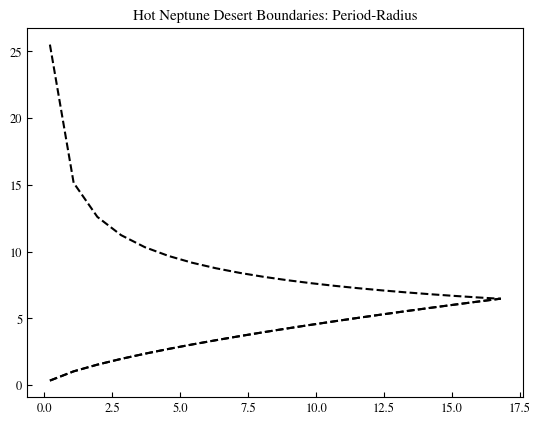

In [16]:
#Code taken from Shubham Kanodia.
####################################################################################################################
#We can then calculate the Hot Neptune Desert boundaries for the Radius-Period space first.
PeriodAxis = np.linspace(0.2, 16.8, 20)
RadiusLower = 10**(-0.31 * np.log10(PeriodAxis) + 1.19)
RadiusUpper = 10**(0.67 * np.log10(PeriodAxis) - 0.01)

plt.title("Hot Neptune Desert Boundaries: Period-Radius")
plt.plot(PeriodAxis, RadiusLower, 'k', ls='--')
plt.plot(PeriodAxis, RadiusUpper, 'k', ls='--', label='Mazeh et al. 2016')
plt.plot(PeriodAxis, RadiusUpper, 'k', ls='--', label='Mazeh et al. 2016')
plt.show()

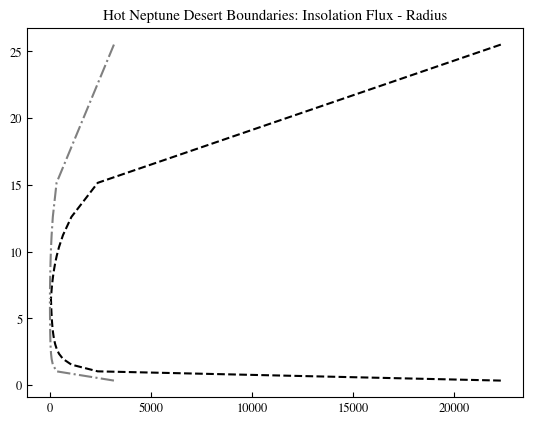

In [18]:
#Code taken from Shubham Kanodia.
####################################################################################################################
#We can also calculate the Hot Neptune Desert boundaries in the Insolation Plot.
#First, we calculate the boundaries for Solar Luminosity.
St_Mass = 1
St_Lum = 1
SemiMajorAxis_PR = np.array([calculate_semi_major_axis(st_mass=St_Mass, pl_orbper=p/365.25).n for p in PeriodAxis])
InsolationAxis_PR = np.array([calculate_insolation_flux(st_lum=St_Lum, pl_orbsmax=a).n for a in SemiMajorAxis_PR])
plt.plot(InsolationAxis_PR, RadiusLower, 'k', ls='--')
#plt.plot(InsolationAxis, RadiusUpper, 'k', ls='--', label='M$_* =1~$M$_{\odot}$; L$_* =1~$L$_{\odot}$')
plt.plot(InsolationAxis_PR, RadiusUpper, 'k', ls='--', label='Neptune Desert')

#We then calculate the boundary for TOI-2431 b's Luminosity.
St_Mass = 0.661
St_Lum = 0.108
SemiMajorAxis_IR = np.array([calculate_semi_major_axis(st_mass=St_Mass, pl_orbper=p/365.25).n for p in PeriodAxis])
InsolationAxis_IR = np.array([calculate_insolation_flux(st_lum=St_Lum, pl_orbsmax=a).n for a in SemiMajorAxis_IR])
plt.plot(InsolationAxis_IR, RadiusLower, 'grey', ls='-.')
plt.plot(InsolationAxis_IR, RadiusUpper, 'grey', ls='-.', label='M$_* =0.6~$M$_{\odot}$; L$_* =0.075~$L$_{\odot}$')

plt.title("Hot Neptune Desert Boundaries: Insolation Flux - Radius")
plt.show()

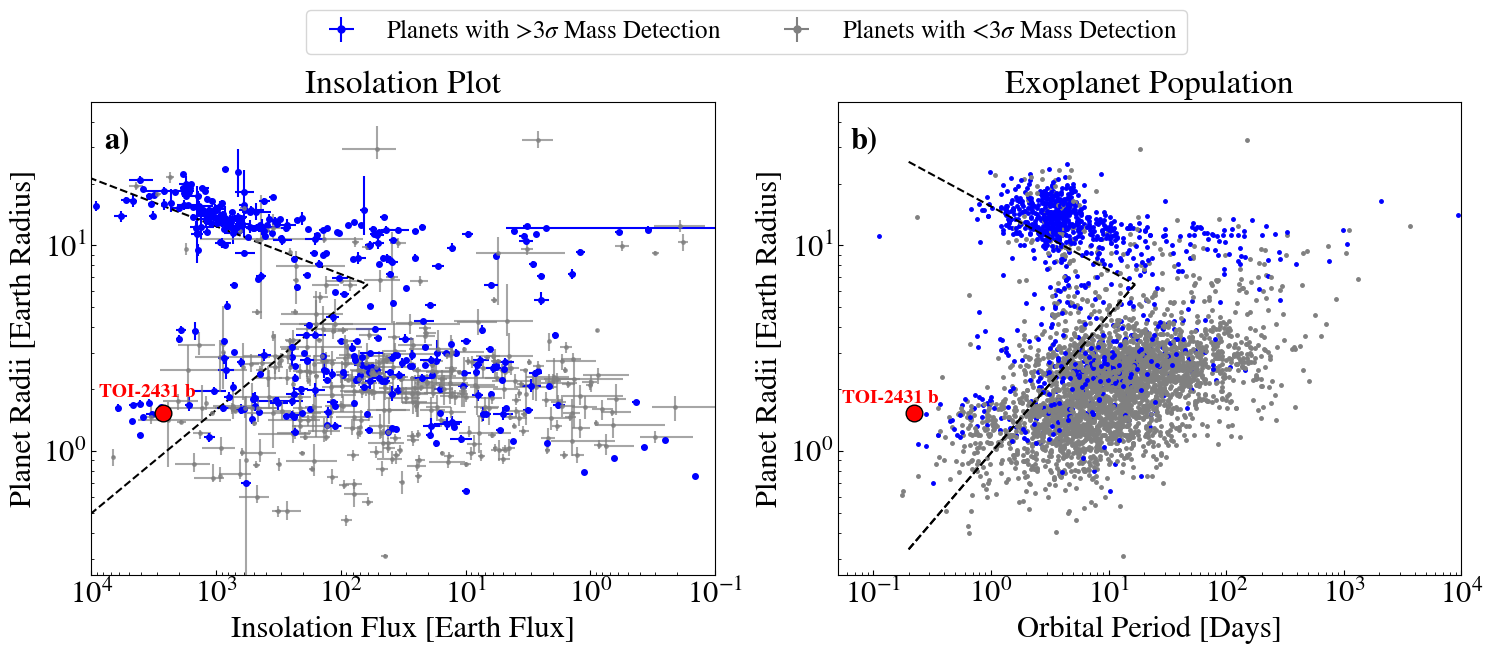

In [33]:
#Now we plot Insolation Plot and the Exoplanet Population.

#We create a figure with two subplots side by side (1 row, 2 columns).
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

#------------------------------------------- Left Side: Insolation Plot -------------------------------------------
for i, name in enumerate(planet_df["pl_name"]):
    if ((np.abs(planet_df["pl_bmasseerr1"].values[i]) <= mass_threshold_pop[i]) & \
        (np.abs(planet_df["pl_bmasseerr2"].values[i]) <= mass_threshold_pop[i])):
        axs[0].errorbar(planet_df["pl_insol"].values[i], planet_df["pl_rade"].values[i],
                        xerr = [[np.abs(planet_df["pl_insolerr2"].values[i])], [planet_df["pl_insolerr1"].values[i]]], 
                        yerr = [[np.abs(planet_df["pl_radeerr2"].values[i])], [planet_df["pl_radeerr1"].values[i]]],
                        fmt = ".", ms = 8, color = "blue")

    else:
        axs[0].errorbar(planet_df["pl_insol"].values[i], planet_df["pl_rade"].values[i],
                        xerr = [[np.abs(planet_df["pl_insolerr2"].values[i])], [planet_df["pl_insolerr1"].values[i]]], 
                        yerr = [[np.abs(planet_df["pl_radeerr2"].values[i])], [planet_df["pl_radeerr1"].values[i]]],
                        fmt = ".", color = "gray", alpha = 0.7)

axs[0].errorbar(insolationflux, radius, xerr = [[insolationflux_lower], [insolationflux_lower]], 
                yerr = [[lower_rad_err], [upper_rad_err]], fmt = "o", color = "red", 
                ecolor = "orange", capsize = 3, markersize = 12, markeredgecolor = "black", markeredgewidth = 1, zorder = 10000)
axs[0].text(insolationflux+6000, radius+0.3, "TOI-2431 b", color = "red", weight = "bold", fontsize = 14, zorder = 20000)

#For the legend purposes!!!
axs[0].errorbar(1e7, 1e7, xerr=1e1, yerr=1e1, label = f"Planets with >3$\sigma$ Mass Detection", fmt = "o", color = "blue")
axs[0].errorbar(1e7, 1e7, xerr=1e1, yerr=1e1, label = f"Planets with <3$\sigma$ Mass Detection", fmt = "o", color = "gray")

axs[0].set_xlabel("Insolation Flux [Earth Flux]", fontsize = 22)
axs[0].set_ylabel("Planet Radii [Earth Radius]", fontsize = 22)
axs[0].set_title("Insolation Plot", fontsize = 24)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlim(1e-1, 1e4)
axs[0].set_ylim(0.25, 50)
axs[0].invert_xaxis()
axs[0].tick_params(axis = "x", which = "major", labelsize = 22)
axs[0].tick_params(axis = "x", which = "minor", labelsize = 17)
axs[0].tick_params(axis = "y", which = "major", labelsize = 22)
#axs[0].legend(loc = "upper right", fontsize = 18)
axs[0].text(0.02, 0.90, "a)", transform=axs[0].transAxes, fontsize=22, fontweight="bold")

#Hot Neptune Desert Boundaries
axs[0].plot(InsolationAxis_PR, RadiusLower, 'k', ls='--')
axs[0].plot(InsolationAxis_PR, RadiusUpper, 'k', ls='--')

# axs[0].plot(InsolationAxis_IR, RadiusLower, 'grey', ls='-.')
# axs[0].plot(InsolationAxis_IR, RadiusUpper, 'grey', ls='-.')

#--------------------------------- Right Side: Exoplanet Population ---------------------------------
for i, name in enumerate(planet_df["pl_rade"]):
    if ((np.abs(planet_df["pl_bmasseerr1"].values[i]) <= mass_threshold_pop[i]) & \
        (np.abs(planet_df["pl_bmasseerr2"].values[i]) <= mass_threshold_pop[i])):
        axs[1].plot(planet_df["pl_orbper"].values[i], planet_df["pl_rade"].values[i], ".", color = "blue")

    else:
        axs[1].plot(planet_df["pl_orbper"].values[i], planet_df["pl_rade"].values[i], ".", color = "gray")

axs[1].errorbar(period, radius, xerr = [[lower_per_err], [upper_per_err]], 
                yerr = [[lower_rad_err], [upper_rad_err]], fmt = "o", color = "red", 
                ecolor = "orange", capsize = 3, markeredgecolor = "black", markeredgewidth = 1, markersize = 12)
axs[1].text(period-0.170, radius+0.18, "TOI-2431 b", color = "red", weight = "bold", fontsize = 14)
axs[1].set_xlabel("Orbital Period [Days]", fontsize = 22)
axs[1].set_ylabel("Planet Radii [Earth Radius]", fontsize = 22)
axs[1].set_title("Exoplanet Population", fontsize = 24)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlim(0.05, 10000)
axs[1].set_ylim(0.25, 50)
axs[1].tick_params(axis = "x", which = "major", labelsize = 22)
axs[1].tick_params(axis = "y", which = "major", labelsize = 22)
#axs[1].legend(loc = "upper right", fontsize = 15)
axs[1].text(0.02, 0.90, "b)", transform=axs[1].transAxes, fontsize=22, fontweight="bold")

#Hot Neptune Desert Boundaries
axs[1].plot(PeriodAxis, RadiusLower, 'k', ls='--')
axs[1].plot(PeriodAxis, RadiusUpper, 'k', ls='--')
axs[1].plot(PeriodAxis, RadiusUpper, 'k', ls='--')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fancybox=True, fontsize=18)

plt.tight_layout()
plt.savefig("toi_2431_insolation_and_exoplanet_population.png", dpi = 500, bbox_inches = "tight")
plt.show()